## Reciprocal connections as a metric of complexity 

We analyze reciprocal connection densities across neighborhoods as a measure of network complexity in 

* C. elegans (last stage) of *Witvliet et al:* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8756380/  
* Drosophila larva of *Winding et al., 2023* https://www.science.org/doi/10.1126/science.add9330 
* MICrONS data set of the *IARPA MICrONS mm^3 dataset* https://www.microns-explorer.org/cortical-mm3 
* The V5 version of the Blue Brain Project model of https://www.cell.com/fulltext/S0092-8674(15)01191-5


The data used here was generated using `../code/run_average_complexity_simplices.py`  and `../code/complexity_{connectome}.py"` for `connectome` in `Celegans`, `Drosophila`, `MICrONS`, and  `BBP`

In [1]:
import pandas as pd 
import numpy as np 
import pickle
from scipy import stats 
import pickle
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import sys 
import os
sys.path.append('../../../library')
from plotting_utils import agg_along_dims_single

In [2]:
# Load average neighborhood complexity across simplices from precomputed data.
path_in = f"../../data/complexity_by_dimension_all_connectomes.pkl"
with open(path_in, 'rb') as f:
    stats_ori_and_controls = pickle.load(f)
stats_all=stats_ori_and_controls["original"]
# Load and format precomputed data of neighborhood complexity 
root='/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/'
connectomes=["Celegans", "Drosophila", "MICrONS", "BBP"]
base_graphs=['original', 'ER', 'CM', 'distance']
data={conn:{} for conn in connectomes}
for conn in connectomes: 
    gtypes=base_graphs if conn in ['MICrONS', 'BBP'] else ['original','CM', 'ER']
    for base_graph in gtypes:
        data[conn][f'df_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_{base_graph}.pkl')
        data[conn][f'df_{base_graph}_CM']=pd.read_pickle(f'{root}props_{conn}_{base_graph}_CM.pkl')
        # For additional visualization of top/bottom neighborhoods
        data[conn][f'sc_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_simplex_counts_{base_graph}.pkl') 

# Load complexity 
cpx_data = {}
for conn in connectomes:
    dfs = []
    for graph in base_graphs:
        if graph == "distance" and conn in ["Celegans", "Drosophila"]:
            continue
        df = pd.read_pickle(os.path.join(root, "props_%s_%s.pkl" % (conn, graph)))
        df["graph"] = graph
        dfs.append(df[["graph", "wasserstein_deg_total", "euclidean_edges_sc"]])
    cpx_data[conn] = pd.concat(dfs, ignore_index=True)

In [3]:
# Plotting functions 
def kde_and_regress(ax, df, x, y, color, return_stats=False):
    x=df[x]; y=df[y] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    ax.plot(x, x*regress.slope+regress.intercept, color=color, label=f"{regress.rvalue:.2f}")
    sns.kdeplot(data=df, x=x, y=y, fill=True, ax=ax, color=color)
    ax.set_ylabel('');     ax.set_xlabel('')
    ax.spines[["right", "top"]].set_visible(False)
    if return_stats:
        return ax, regress
    else:
        return ax
def kde_ori_single_control(ax, conn, base_prop, complexity_prop, control="ER", return_stats=False):
    axes=[ax]
    base_graph="original"
    ax, regress=kde_and_regress(ax, data[conn][f"df_{base_graph}"],  x=base_prop, y=complexity_prop, color=colors[base_graph],
                       return_stats=True)

    
    base_graph=control
    left, bottom, width, height= [0.25, 0.85, .2, 0.2]
    ax0=ax.inset_axes([left, bottom, width, height])
    axes.append(ax0)
    ax0, regress0=kde_and_regress(ax0, data[conn][f"df_{base_graph}"],  x=base_prop, y=complexity_prop, 
                                  color=colors[base_graph], return_stats=True)
    
    # Make r-value legend
    legs=[x.get_legend_handles_labels() for x in axes]
    legend=[l[0][0] for l in legs], [l[1][0] for l in legs]

    # Ticksize 
    ax.tick_params(axis='both', labelsize=ticksize)
    ax0.tick_params(axis='both', labelsize=ticksize-2)
    if return_stats: 
        return legend, {"base":regress, "control":regress0}
    else: 
        return legend
def plot_outliers(axes, base_prop, q=0.01,
                  props = ['euclidean_edges_sc', 'wasserstein_deg_total'],  base_graph='original'):
    # Organize data into DataFrame for seaborn 
    champs=[]
    for conn in connectomes:
        df=data[conn][f'df_{base_graph}']
        top=df[df[base_prop]>=df.quantile(1-q)[base_prop]][props]
        top["type"]="top"
        bottom=df[df[base_prop]<=df.quantile(q)[base_prop]][props]
        bottom["type"]="bottom"
        tb=pd.concat([top, bottom])
        tb["connectome"]=conn
        champs.append(tb)
    champs=pd.concat(champs)
    for i, prop in enumerate(props):
        sns.violinplot(champs, x="connectome", y=prop, hue="type",ax=axes[i], split=True, 
                   palette=colors, inner="quartile", saturation=0.5, linewidth=0.5)
def plot_simplicial_av(ax, conn, prop, base_graph, label,ms, color, 
                       stype="maximal", node_type="all", normalize_at_dim_1=True, 
                       linestyle="solid", marker="o"):
    plot_df=agg_along_dims_single(stats_ori_and_controls[base_graph])[stype][conn][prop][node_type]
    dims = plot_df.index
    y=plot_df["mean"]; err=plot_df["sem"]
    if normalize_at_dim_1:
        ax.plot(dims, y/y.loc[1], label=label, ms=2, color=colors[conn],linestyle=linestyle,marker=marker)
        ax.fill_between(dims, (y-err)/y.loc[1],(y+err)/y.loc[1],color=colors[conn], alpha=0.5)
    else:
        ax.plot(dims, y, label=label, ms=2, color=colors[conn],linestyle=linestyle,marker=marker)
        ax.fill_between(dims, (y-err),(y+err),color=colors[conn], alpha=0.5)
    return ax 

In [4]:
# Font sizes and color and marker schemes
titlesize=8
labelsize=6
ticksize=6
marker_size=2
conversion=2.54
#conversion=1.5
scatter_kws={'alpha':0.1, 's':2}

cmap=plt.cm.Dark2
colors={
    'original':'indianred',#cmap(3), 
    'CM':cmap(2), 
    'ER':cmap(0), 
    'distance':"tab:brown", 
    'BBP':"steelblue", 
    'MICrONS':"palevioletred",
    'Celegans':"darkseagreen",
    'Drosophila':"chocolate"
}

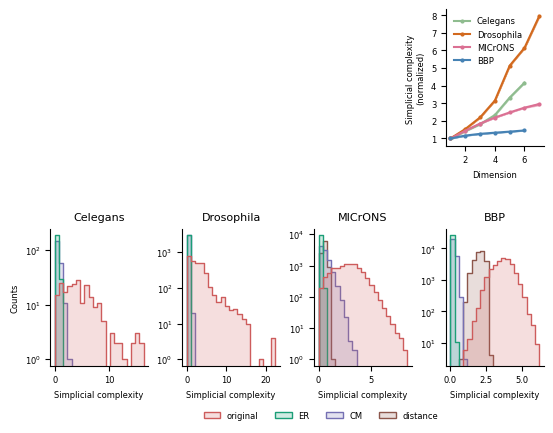

In [5]:
# Main Figure 
width=21*0.7/conversion
rows, cols = 3, 4

fig, axs =plt.subplots(rows,cols,figsize=(width*1.1, width*(rows-1)*1.6/cols),
                       height_ratios=[1,0.3, 1])
# Complexity vs maximal simplicial structure (normalized by values at source)
axs[0,0].axis("off"); axs[0,1].axis("off"), axs[0,2].axis("off") # Space for cartoon 

k=3;prop= 'euclidean_edges_sc'#'wasserstein_deg_total'#
for conn in connectomes:
    axs[0,k]=plot_simplicial_av(axs[0,k], conn, prop, base_graph="original", label=conn,
                                ms=marker_size, color=colors[conn], stype="maximal", node_type="all", normalize_at_dim_1=True)
    axs[0,k].set_xlabel("Dimension", fontsize=labelsize) 
    axs[0,k].spines[["top", "right"]].set_visible(False)
    axs[0,k].set_xticks([2,4,6])
axs[0,3].legend(frameon=False, fontsize=labelsize)
axs[0,3].set_ylabel("Simplicial complexity \n(normalized)", fontsize=labelsize)    

# Complexity on neighborhoods 
feature="euclidean_edges_sc"
for i, complexity_prop in enumerate(['euclidean_edges_sc'], start=2):
    for j, conn in enumerate(connectomes):
        # Space for icon 
        axs[1,j].axis("off")
        legend=True if conn =="BBP" else False
        sns.histplot(x=feature, hue="graph", bins=21,
                     element="step", palette=colors, legend=legend, alpha=0.2, data=cpx_data[conn], ax=axs[i,j])
        if conn == "BBP": 
            l=axs[i,j].get_legend_handles_labels()
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,j].set_ylabel("")
        axs[i,j].set_title(conn, fontsize=titlesize)
        axs[i,j].set_xlabel("Simplicial complexity", fontsize=labelsize)
        axs[i,j].set_yscale("log")
        axs[i,j].minorticks_off()
axs[2,0].set_ylabel("Counts", fontsize=labelsize)

for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Adjust
sns.move_legend(axs[2,-1], loc=4, title='', ncols=4, frameon=False, bbox_to_anchor=(0,-0.45), fontsize=labelsize)

plt.subplots_adjust(wspace=.35)
             

fig.savefig("figs/complexity_main_all_connectomes_kde.pdf", transparent=True, bbox_inches='tight')

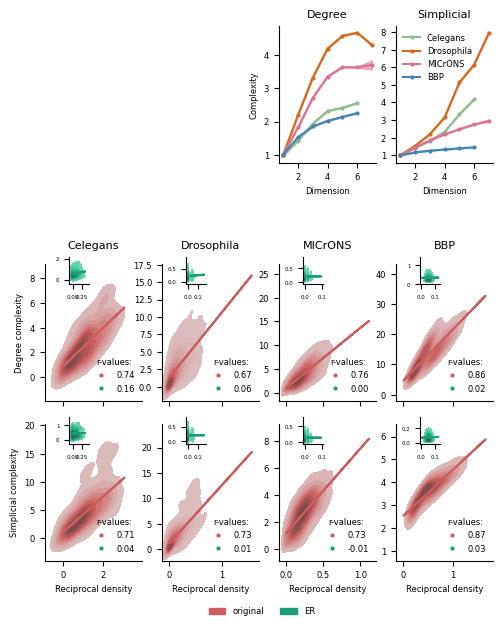

In [6]:
width=21*0.7/conversion
rows, cols = 4, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols),
                       height_ratios=[1,0.4, 1, 1])
# Complexity vs maximal simplicial structure (normalized by values at source)
axs[0,0].axis("off"); axs[0,1].axis("off") # Space for cartoon 

axs[0,2].set_title(f"Degree", fontsize=titlesize) 
axs[0,3].set_title(f"Simplicial", fontsize=titlesize) 
for k, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc'], start=2):
    for conn in connectomes:
        axs[0,k]=plot_simplicial_av(axs[0,k], conn, prop, base_graph="original", label=conn,
                                    ms=marker_size, color=colors[conn], stype="maximal", node_type="all", normalize_at_dim_1=True)
        axs[0,k].set_xticks([2,4,6])
        axs[0,k].set_xlabel("Dimension", fontsize=labelsize) 
        axs[0,k].spines[["top", "right"]].set_visible(False)
axs[0,3].legend(frameon=False, fontsize=labelsize)
axs[0,2].set_ylabel("Complexity", fontsize=labelsize)    

# Reciprocal density vs complexity 
control="ER" # CM
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc'], start=2):
    for j, conn in enumerate(connectomes):
        # Space for icon 
        axs[1,j].axis("off")
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
               for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[-1,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        axs[2,j].set_xticklabels([])
        axs[2,j].set_title(f"{conn}", fontsize=titlesize)

    
axs[2,0].set_ylabel("Degree complexity", fontsize=labelsize)
axs[3,0].set_ylabel("Simplicial complexity", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]
             
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.02], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_all_connectomes_kde.pdf", transparent=True, bbox_inches='tight')

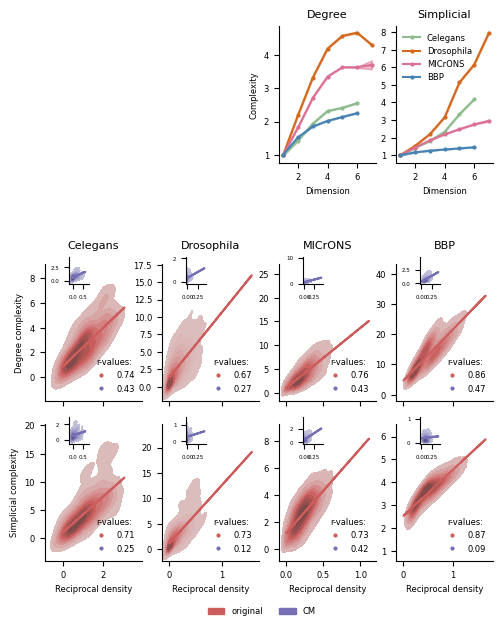

In [7]:
# Version with CM control instead (for the record) 
width=21*0.7/conversion
rows, cols = 4, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols),
                       height_ratios=[1,0.4, 1, 1])
# Complexity vs maximal simplicial structure (normalized by values at source)
axs[0,0].axis("off"); axs[0,1].axis("off") # Space for cartoon 

axs[0,2].set_title(f"Degree", fontsize=titlesize) 
axs[0,3].set_title(f"Simplicial", fontsize=titlesize) 
for k, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc'], start=2):
    for conn in connectomes:
        axs[0,k]=plot_simplicial_av(axs[0,k], conn, prop, base_graph="original", label=conn,
                                    ms=marker_size, color=colors[conn], stype="maximal", node_type="all", normalize_at_dim_1=True)
        axs[0,k].set_xlabel("Dimension", fontsize=labelsize) 
        axs[0,k].spines[["top", "right"]].set_visible(False)
        axs[0,k].set_xticks([2,4,6])
axs[0,3].legend(frameon=False, fontsize=labelsize)
axs[0,2].set_ylabel("Complexity", fontsize=labelsize)    

# Reciprocal density vs complexity 
control="CM" # ER
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc'], start=2):
    for j, conn in enumerate(connectomes):
        # Space for icon 
        axs[1,j].axis("off")
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
               for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[-1,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        axs[2,j].set_xticklabels([])
        axs[2,j].set_title(f"{conn}", fontsize=titlesize)

    
axs[2,0].set_ylabel("Degree complexity", fontsize=labelsize)
axs[3,0].set_ylabel("Simplicial complexity", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]
             
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.02], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_all_connectomes_kde_CM_control.pdf", transparent=True, bbox_inches='tight')

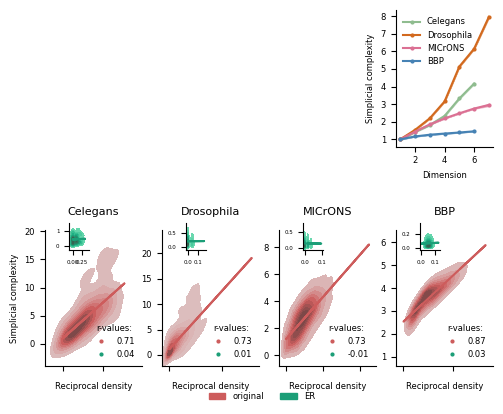

In [8]:
# Main Figure - old version
width=21*0.7/conversion
rows, cols = 3, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols),
                       height_ratios=[1,0.3, 1])
# Complexity vs maximal simplicial structure (normalized by values at source)
axs[0,0].axis("off"); axs[0,1].axis("off"), axs[0,2].axis("off") # Space for cartoon 

k=3;prop= 'euclidean_edges_sc'#'wasserstein_deg_total'#
for conn in connectomes:
    axs[0,k]=plot_simplicial_av(axs[0,k], conn, prop, base_graph="original", label=conn,
                                ms=marker_size, color=colors[conn], stype="maximal", node_type="all", normalize_at_dim_1=True)
    axs[0,k].set_xlabel("Dimension", fontsize=labelsize) 
    axs[0,k].spines[["top", "right"]].set_visible(False)
    axs[0,k].set_xticks([2,4,6])
axs[0,3].legend(frameon=False, fontsize=labelsize)
axs[0,3].set_ylabel("Simplicial complexity", fontsize=labelsize)    

# Reciprocal density vs complexity 
control="ER" # CM
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['euclidean_edges_sc'], start=2):
    for j, conn in enumerate(connectomes):
        # Space for icon 
        axs[1,j].axis("off")
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
               for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[-1,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        axs[2,j].set_xticklabels([])
        axs[2,j].set_title(f"{conn}", fontsize=titlesize)

    
axs[2,0].set_ylabel("Simplicial complexity", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]
             
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.02], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_main_all_connectomes_kde.pdf", transparent=True, bbox_inches='tight')

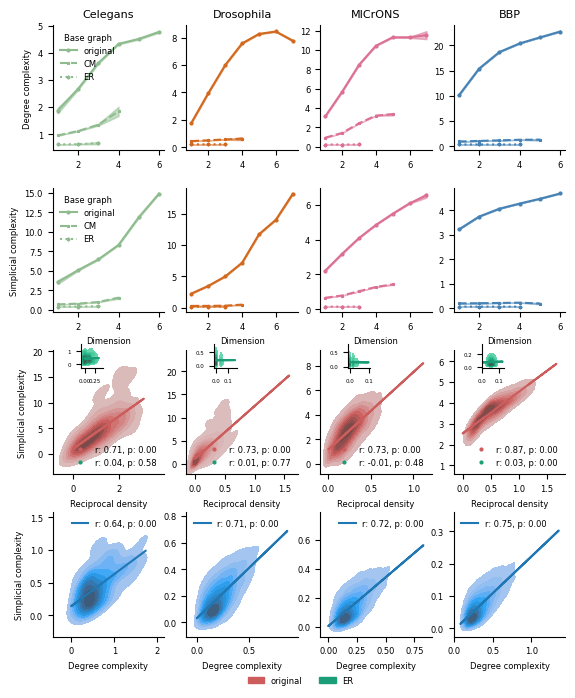

In [9]:
# aqui aqui 
# Supplementary figure 
markers = {"original" : "o", 
           "CM" :  "*", 
           "ER": "P"}
linestyles = {"original" : "solid", 
           "CM" :  "dashed", 
           "ER": "dotted"}
width=21*0.8/conversion
rows, cols = 4, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols))
# Complexity vs maximal simplicial structure (normalized by values at source)

for i, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc']):
    for k, conn in enumerate(connectomes):
        axs[0,k].set_title(f"{conn}", fontsize=titlesize)
        for base_graph in ["original", "CM", "ER"]: #Add linestyle option
            axs[i,k]=plot_simplicial_av(axs[i,k], conn, prop, base_graph=base_graph, label=base_graph,
                                        ms=marker_size, color=colors[conn], 
                                        stype="maximal", node_type="all", normalize_at_dim_1=False,
                                        marker = markers[base_graph], linestyle = linestyles[base_graph])
        axs[i,k].spines[["top", "right"]].set_visible(False)
        axs[1,k].set_xlabel("Dimension", fontsize=labelsize) 
axs[0,0].legend(frameon=False, fontsize=labelsize, title="Base graph", title_fontsize=labelsize)
axs[1,0].legend(frameon=False, fontsize=labelsize, title="Base graph", title_fontsize=labelsize)
axs[0,0].set_ylabel("Degree complexity", fontsize=labelsize)    
axs[1,0].set_ylabel("Simplicial complexity", fontsize=labelsize)    

# Simplicial complexity vs reciprocal density
control="ER" # CM is also an option
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['euclidean_edges_sc'], start=2):
    for j, conn in enumerate(connectomes):
        legend, regressdict = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control, return_stats=True)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
                   for base_graph in ['original']+[control]]
        full_labels=[f"r: {regressdict[gtype].rvalue:.2f}, p: {regressdict[gtype].pvalue:.2f}" for gtype in regressdict.keys()]
        axs[i,j].legend(handles, full_labels, frameon=False, loc=4, 
                        fontsize=labelsize,title_fontsize=ticksize)
        axs[i,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        #axs[2,j].set_xticklabels([])
axs[2,0].set_ylabel("Simplicial complexity", fontsize=labelsize)

# Simplicial complexity vs degree complexity
x_complexity_prop='wasserstein_deg_total'
y_complexity_prop='euclidean_edges_sc'
i=3
for j, conn in enumerate(connectomes):
    axs[i,j], regress=kde_and_regress(axs[i,j], data[conn][f"df_{base_graph}"], x_complexity_prop, y_complexity_prop, color="C0", return_stats=True)
    h,l=axs[i,j].get_legend_handles_labels()
    full_labels=[f"r: {regress.rvalue:.2f}, p: {regress.pvalue:.2f}"]
    axs[i,j].legend(h, full_labels, frameon=False, fontsize=labelsize)
    axs[i,j].set_xlabel("Degree complexity", fontsize=labelsize)
axs[i,0].set_ylabel("Simplicial complexity", fontsize=labelsize)

    
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]

plt.subplots_adjust(hspace=.3, wspace=.2)            
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.04], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_all_connectomes_kde_supp.pdf", transparent=True, bbox_inches='tight')

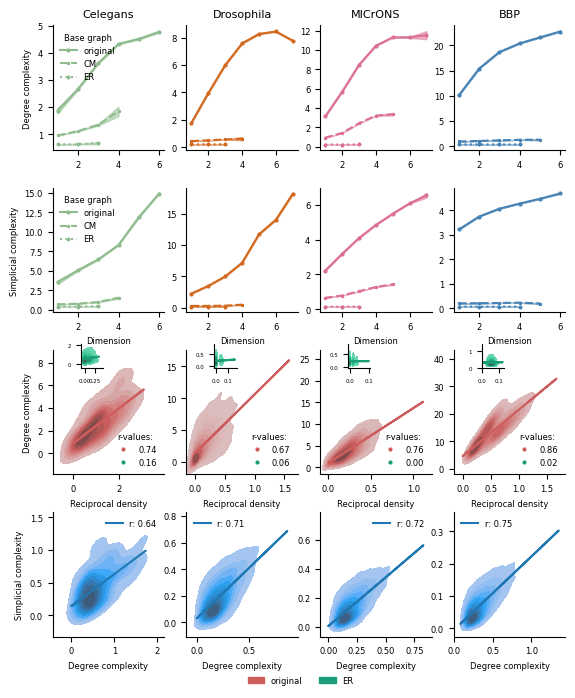

In [10]:
# Supplementary figure - old 
markers = {"original" : "o", 
           "CM" :  "*", 
           "ER": "P"}
linestyles = {"original" : "solid", 
           "CM" :  "dashed", 
           "ER": "dotted"}
width=21*0.8/conversion
rows, cols = 4, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols))
# Complexity vs maximal simplicial structure (normalized by values at source)

for i, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc']):
    for k, conn in enumerate(connectomes):
        axs[0,k].set_title(f"{conn}", fontsize=titlesize)
        for base_graph in ["original", "CM", "ER"]: #Add linestyle option
            axs[i,k]=plot_simplicial_av(axs[i,k], conn, prop, base_graph=base_graph, label=base_graph,
                                        ms=marker_size, color=colors[conn], 
                                        stype="maximal", node_type="all", normalize_at_dim_1=False,
                                        marker = markers[base_graph], linestyle = linestyles[base_graph])
        axs[i,k].spines[["top", "right"]].set_visible(False)
        axs[1,k].set_xlabel("Dimension", fontsize=labelsize) 
axs[0,0].legend(frameon=False, fontsize=labelsize, title="Base graph", title_fontsize=labelsize)
axs[1,0].legend(frameon=False, fontsize=labelsize, title="Base graph", title_fontsize=labelsize)
axs[0,0].set_ylabel("Degree complexity", fontsize=labelsize)    
axs[1,0].set_ylabel("Simplicial complexity", fontsize=labelsize)    

# Reciprocal density vs complexity 
control="ER" # CM is also an option
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['wasserstein_deg_total'], start=2):
    for j, conn in enumerate(connectomes):
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
                   for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[i,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        #axs[2,j].set_xticklabels([])

# Simplicial vs degree complexity
x_complexity_prop='wasserstein_deg_total'
y_complexity_prop='euclidean_edges_sc'
i=3
for j, conn in enumerate(connectomes):
    axs[i,j]=kde_and_regress(axs[i,j], data[conn][f"df_{base_graph}"], x_complexity_prop, y_complexity_prop, color="C0")
    h,l=axs[i,j].get_legend_handles_labels()
    axs[i,j].legend(h, [f"r: {l[0]}"], frameon=False, fontsize=labelsize)
    axs[i,j].set_xlabel("Degree complexity", fontsize=labelsize)
    axs[i,0].set_ylabel("Simplicial complexity", fontsize=labelsize)

    
axs[2,0].set_ylabel("Degree complexity", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]

plt.subplots_adjust(hspace=.3, wspace=.2)            
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.04], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_all_connectomes_kde_supp.pdf", transparent=True, bbox_inches='tight')

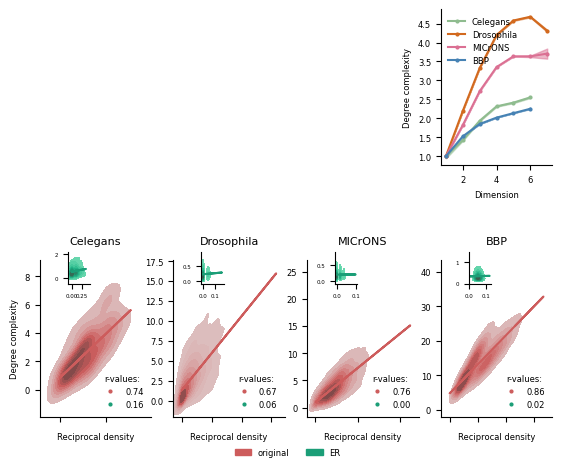

In [11]:
# Version of main Figure with degree complexity instead
width=21*0.8/conversion
rows, cols = 3, 4

fig, axs =plt.subplots(rows,cols,figsize=(width, width*(rows-1)*1.6/cols),
                       height_ratios=[1,0.3, 1])
# Complexity vs maximal simplicial structure (normalized by values at source)
axs[0,0].axis("off"); axs[0,1].axis("off"); axs[0,2].axis("off") # Space for cartoon 

k=3;prop='wasserstein_deg_total'
for conn in connectomes:
    axs[0,k]=plot_simplicial_av(axs[0,k], conn, prop, base_graph="original", label=conn,
                                ms=marker_size, color=colors[conn], stype="maximal", node_type="all", normalize_at_dim_1=True)
    axs[0,k].set_xlabel("Dimension", fontsize=labelsize) 
    axs[0,k].spines[["top", "right"]].set_visible(False)
axs[0,3].legend(frameon=False, fontsize=labelsize)
axs[0,3].set_ylabel("Degree complexity", fontsize=labelsize)    

# Reciprocal density vs complexity 
control="ER" # CM
base_prop='rc_over_nodes'#'rc_over_edges'
for i, complexity_prop in enumerate(['wasserstein_deg_total'], start=2):
    for j, conn in enumerate(connectomes):
        # Space for icon 
        axs[1,j].axis("off")
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
               for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[-1,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        axs[2,j].set_xticklabels([])
        axs[2,j].set_title(f"{conn}", fontsize=titlesize)

    
axs[2,0].set_ylabel("Degree complexity", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]
             
fig.legend(handles=color_box, loc=8, bbox_to_anchor=[0.5,0.02], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_extra_all_connectomes_kde_simplicial.pdf", transparent=True, bbox_inches='tight')